# Dominant Color Extraction
2-Feb-2022

Author: [Ryan Parker](https://github.com/rparkr)

Code taken from my Vehicle Specs Machine Learning project, completed December 2021, for my IS 455 Machine Learning in Python course at Brigham Young University.

## Purpose: return the name of the main color in an image
The code in this notebook takes an image from a URL, crops to the center of the image, reduces the size of the center crop (to speed up computation), then finds the number of colors represented in that center crop and returns the named color that is closest to the most-prevalent (i.e., dominant) color in the image.

Assumptions include: the center of the image has the main subject, and the main color in the center of the image is representative of the entire image.

# Pre-process image: convert to array of RGB pixels

In [ ]:
def preprocess_image(img_path, is_url=True, scale_factor=4, scale_mode='resize', 
                     crop_center=True, display_img=False, quiet=False, scale_rgb=False):
    '''
    Retrieve an image from a URL, crop it to the center tile of
    a 3x3 grid from the image, scale the image down to reduce its
    dimensionality, and then reshape the image pixels into a `numpy`
    array of dimensions [n_pixels, 3], with as many rows as their
    are pixels in the image (width * height), and three columns
    with the Red, Blue, and Green values of each pixel.

    ## Parameters
    `img_path` : str
    The URL or path of the image to be processed.

    `is_url` : bool, default=True
    If `img_path` is a URL to an image, set this parameter to `True`.
    Otherwise, the `img_path` must be a file path to the image.
    
    `scale_factor` : int, default=4
    The factor by which the image will be downsized to reduce its
    dimensionality and speed up processing. The resulting dimensions
    of the image will be: (width / scale_factor, height / scale_factor).

    `scale_mode` : {'resize', 'reduce'}, default='resize'
    Sets the Pillow function to use for rescaling the image. 
    When rescaling by a small scale_factor (such as 2), `resize`
    produces a more accurate picture, but is slower than `rescale`.
    For scale_factor values greater than 2, both methods produce
    similar performance and resulting images.
    
    `crop_center` : bool, default=True
    Whether to crop the image to the center of a 3x3 grid prior
    to rescaling the image. This is most helpful when the center
    of the image focuses on the subject of interest rather than
    the unimportant background of the image.
    
    `display_img` : bool, default=False
    Whether to display the image as it is processed.

    `quiet` : bool, default=False
    Set to True to prevent the function from printing any output.

    `scale_rgb` : bool, default=False
    If True, scale RGB values on a [0,1] scale by dividing
    each value by 255. Some functions work best with scaled
    RGB values. For example, see: https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
    This setting impacts only the NumPy array returned
    from this function and does not affect earlier steps.

    ## Dependencies
    This function uses the following packages and modules:
    * `Pillow`
    * `requests`
    * `numpy`
    * `matplotlib.pyplot`
    * `io.BytesIO()`
    '''
    # for loading and working with images
    from PIL import Image
    # for reshaping the image into a 2D array
    import numpy as np

    # Optional imports, depending on settings
    if is_url:
        # for requesting images from URLs
        import requests
        # for converting bytes objects (image files) into PIL image objects
        from io import BytesIO

    if display_img:
        # for displaying the image as it is processed
        import matplotlib.pyplot as plt
    
    # ========================
    # Load the image
    # ========================
    if is_url:
        # Retrieve the content of the img_url, a binary object (i.e., a file, made of bytes rather than text)
        pil_img = Image.open(BytesIO(requests.get(img_path).content))
    else:
        pil_img = Image.open(img_path)
    
    # Record image size
    img_width = pil_img.size[0]
    img_height = pil_img.size[1]
    if not quiet:
        print(f'Input image dimensions: width={img_width}, height={img_height}')

    if display_img:
        # Display the image using Matplotlib's plotting function
        plt.imshow(pil_img)
        plt.show()

    # =============================
    # Divide image into 3x3 grid
    # =============================
    if crop_center:
        # (x,y) coordinates for the bounding box surrounding
        # the center grid section of a 3x3 grid
        one_third_width = int(round(img_width / 3, 0))
        one_third_height = int(round(img_height / 3, 0))
        
        left = one_third_width
        top = one_third_height
        right = one_third_width * 2
        bottom = one_third_height * 2
        box_center = (left, top, right, bottom)

        if not quiet:
            print('\nImage cropped to center of 3x3 grid.', 
                f'\nNew dimensions: width={one_third_width}, height={one_third_height}\n', sep='') 

        if display_img:
            # Create [x,y] lists to draw 4 lines on the image to separate it into a 3x3 grid
            # See: https://www.kite.com/python/answers/how-to-draw-a-line-between-two-points-in-matplotlib-in-python
            # Also: https://www.geeksforgeeks.org/plot-a-point-or-a-line-on-an-image-with-matplotlib/
            line_endpoints = [
                [img_width / 3, 0],                  # top coordinate of first (left) vertical line
                [img_width / 3, img_height],         # bottom coordinate of first vertical line
                [(img_width / 3) * 2, 0],            # top coordinate of second (right) vertical line
                [(img_width / 3) * 2, img_height],   # bottom coordinate of second vertical line
                [0, img_height / 3],                 # top-left coordinate of first (top) horizontal line
                [img_width, img_height / 3],         # top-right coordinate of first horizontal line
                [0, (img_height / 3) * 2],           # top-left coordinate of second (bottom) horizontal line
                [img_width, (img_height / 3) * 2]    # top-right coordinate of second horizontal line
            ]
            # https://matplotlib.org/stable/gallery/color/named_colors.html
            # https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
            x_coors = [item[0] for item in line_endpoints]
            y_coors = [item[1] for item in line_endpoints]
            # Draw 3x3 gridlines on the image
            plt.plot(x_coors[:2], y_coors[:2], color='lime', linestyle='dashed', linewidth=2)
            plt.plot(x_coors[2:4], y_coors[2:4], color='lime', linestyle='dashed', linewidth=2)
            plt.plot(x_coors[4:6], y_coors[4:6], color='lime', linestyle='dashed', linewidth=2)
            plt.plot(x_coors[6:], y_coors[6:], color='lime', linestyle='dashed', linewidth=2)
            plt.title('3x3 grid')
            plt.imshow(pil_img)
            plt.show()
            # Display only the cropped portion
            plt.title('Center of 3x3 grid')
            plt.imshow(pil_img.crop(box=(left, top, right, bottom)))
            plt.show()
    
    # ======================================
    # Rescale image to reduce dimensionality
    # ======================================
    if scale_mode == 'resize':
        if crop_center:
            new_width = int(round(one_third_width / scale_factor, 0))
            new_height = int(round(one_third_height / scale_factor, 0))
            img_rescaled = pil_img.resize(
                size=(new_width, new_height), 
                box=(left, top, right, bottom))
        else:
            new_width = int(round(img_width / scale_factor, 0))
            new_height = int(round(img_height / scale_factor, 0))
            img_rescaled = pil_img.resize(size=(new_width, new_height))
    else:
        # scale_mode is 'reduce'
        if crop_center:
            img_rescaled = pil_img.reduce(
                factor=scale_factor, 
                box=(left, top, right, bottom))
        else:
            new_width = int(round(img_width / scale_factor, 0))
            new_height = int(round(img_height / scale_factor, 0))
            img_rescaled = pil_img.reduce(factor=scale_factor)
    
    if not quiet:
        print(f'Resized by 1/{scale_factor}x')
        print(f'Resized image dimensions: width={img_rescaled.size[0]}, height={img_rescaled.size[1]}\n')
    # Display the resized image
    if display_img:
        plt.title(f'Resized by 1/{scale_factor}x')
        plt.imshow(img_rescaled)
        plt.show()

    # ==================================================
    # Reshape image to a 2D array of shape [n_pixels, 3]
    # ==================================================
    # # rows = number of pixels, # columns = 3 (for RGB)
    # Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
    pixel_array = np.array(img_rescaled)
    h, w, c = pixel_array.shape
    pixel_array = np.reshape(pixel_array, (w * h, c))
    if scale_rgb:
        # scale RGB values on [0, 1] scale rather than [0, 255]
        pixel_array = pixel_array / 255
    if not quiet:
        print('Image converted to pixel array of shape (height * width, RGB): ', pixel_array.shape, sep='')

    # ================================
    # Return the processed image array
    # ================================
    return pixel_array

# Determine optimal number of clusters
Uses the "elbow" method. The elbow method means to plot the scores for n-clusters and note the slope of the line. The optimal number of clusters is the point where the slope bends sharply to flatten out from its initial steep decline.

Uses `sklearn.cluster.KMeans().inertia_` attribute, which is the "sum of squared distances of samples to their closest cluster center" according to the [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). See also [KMeans](https://scikit-learn.org/stable/modules/clustering.html#k-means) on sklearn's [Clustering](https://scikit-learn.org/stable/modules/clustering.html) documentation.

## Elbow method: explained through plotting

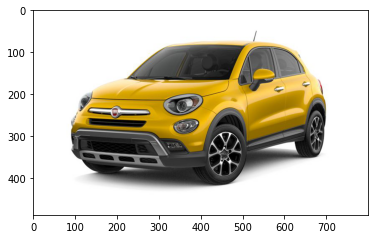

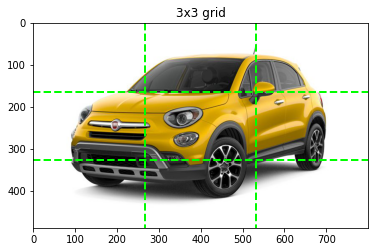

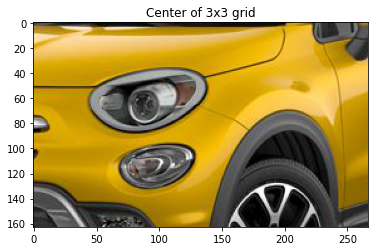

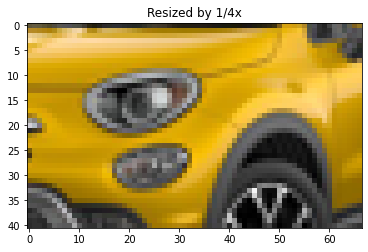

Optimal number of clusters is: 3

Dominant RGB value is: [197, 151, 8]

              Dominant_RGB   Inertia    Slope   Change
n_clusters                                            
2           [209, 164, 33]  10470897 -3777871        0
3            [197, 151, 8]   6693026 -2352810  1425061
4            [201, 154, 9]   4340216 -1043203  1309607
5           [215, 166, 12]   3297013  -831291   211912
6           [219, 169, 13]   2465722  -417096   414195
7            [211, 162, 5]   2048626  -453509    36413
8            [211, 161, 5]   1595117  -205679   247830
9            [211, 161, 5]   1389438  -173402    32277
10           [201, 153, 4]   1216036        0        0



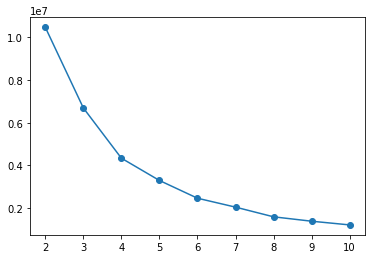

In [ ]:
# Demonstration of the elbow method
# =================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
# MiniBatchKMeans is faster that KMeans and produces almost equivalent results
from sklearn.cluster import MiniBatchKMeans
# Counter is used to count the number of pixels in each cluster
from collections import Counter

inertia_scores = []
rgb_centers = []

pixel_array = preprocess_image(
        img_path='https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/8547.jpg',
        is_url=True, 
        scale_factor=4, 
        scale_mode='resize', 
        crop_center=True, 
        display_img=True,
        quiet=True, 
        scale_rgb=False)

for n in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=n, random_state=0).fit(pixel_array)
    inertia_scores.append(int(round(kmeans.inertia_, 0)))
    # Count labels to compare size of clusters
    # See: https://adamspannbauer.github.io/2018/03/02/app-icon-dominant-colors/
    label_counts = Counter(kmeans.labels_)
    # Find the name (integer) of the largest cluster
    largest_cluster = label_counts.most_common(1)[0][0]
    dominant_rgb = [int(round(item, 0)) for item in kmeans.cluster_centers_[largest_cluster]]
    rgb_centers.append(dominant_rgb)

# Calculate the slopes and changes in slope
slopes = []
changes = []
for n in range(len(inertia_scores)):
    if n < 1:
        changes.append(0)
        slopes.append(inertia_scores[n+1] - inertia_scores[n])
    elif n == len(inertia_scores)-1:
        slopes.append(0)
        changes.append(0)
    else:
        slopes.append(inertia_scores[n+1] - inertia_scores[n])
        # Change in slope can be calculated staring from the second point
        changes.append(abs(slopes[n] - slopes[n-1]))

inertia_comp = {
    'n_clusters': range(2,11),
    'Dominant_RGB': rgb_centers,
    'Inertia': inertia_scores,
    'Slope': slopes,
    'Change': changes,
}

# Find the optimal number of clusters based on the
# maximum change in slopes. Add 2 to that index
# since the n_clusters starts at 2.
max_change_nclusters = changes.index(max(changes)) + 2
dominant_rgb = rgb_centers[changes.index(max(changes))]
print(f'Optimal number of clusters is: {max_change_nclusters}\n')
print(f'Dominant RGB value is: {dominant_rgb}\n')

# Display the data
print(pd.DataFrame(inertia_comp).set_index('n_clusters'), '\n', sep='')

# Plot the chart
x_vals = list(range(2, 11))
y_vals = inertia_scores
plt.plot(x_vals, y_vals, marker='o')
plt.show()

## Optimal clusters using the Elbow method

In [ ]:
def optimal_nclusters_elbow(data, max_clusters=10, random_state=0, plot_data=False, quiet=False):
    '''
    Calculates the optimal number of clusters using the
    'elbow method', which is based on the changes in
    inertia between different numbers of clusters.

    Returns a dictionary with the best number of clusters
    using the elbow method criteria:
    ```
    {
        n_clusters: value,
        dominant_rgb: [R, G, B]
    }
    ```

    Notably, this function is very fast.

    Documentation: https://scikit-learn.org/stable/modules/clustering.html#k-means

    ## Parameters
    `data` : {array, matrix}
    The data (usually called X in sklearn) upon which
    to apply clustering. For image clustering, this
    should be a NumPy array of shape [n_pixels, 3], or one
    row for every pixel, with three columns representing
    the Red, Green, and Blue values of the pixel on that row.

    `max_clusters` : int, default=10
    The maximum number of clusters to test. Must be >= 3.
    This function applies the MiniBatchKMeans algorithm 
    from 2 to max_clusters number of clusters.

    `random_state` : int, default=0
    Set the random_state to some integer for best comparison
    between number of clusters. 
    Set to `None` to enable different random selections
    for each number of clusters (not recommended).

    `plot_data` : bool, default=False
    Whether to plot the data to visualize the elbow method.

    `quiet` : bool, default=False
    Set to True to prevent the function from printing any output.

    ## Dependencies
    This function relies on the following:
    * `pandas`
    * `matplotlib`
    * `sklearn.cluster.MiniBatchKMeans`
    * `collections.Counter`
    '''
    import pandas as pd
    import matplotlib.pyplot as plt
    # MiniBatchKMeans is faster that KMeans and produces almost equivalent results
    from sklearn.cluster import MiniBatchKMeans
    # Counter is used to count the number of pixels in each cluster
    from collections import Counter

    # Ensure max_clusters is at least 3, which is needed
    # to compute the change in slope (slope requires 2 points to compute,
    # and change in slope requires 2 slopes, or 3 points)
    if max_clusters < 3:
        max_clusters = 3

    inertia_scores = []
    rgb_centers = []

    for n in range(2, max_clusters+1):
        kmeans = MiniBatchKMeans(n_clusters=n, random_state=random_state).fit(data)
        inertia_scores.append(int(round(kmeans.inertia_, 0)))
        # Count labels to compare size of clusters
        # See: https://adamspannbauer.github.io/2018/03/02/app-icon-dominant-colors/
        label_counts = Counter(kmeans.labels_)
        # Find the name (integer) of the largest cluster
        largest_cluster = label_counts.most_common(1)[0][0]
        dominant_rgb = [int(round(item, 0)) for item in kmeans.cluster_centers_[largest_cluster]]
        rgb_centers.append(dominant_rgb)

    # Calculate the slopes and changes in slope
    slopes = []
    changes = []
    for n in range(len(inertia_scores)):
        if n < 1:
            # Slope can be calculated starting from the second point
            slopes.append(0)
            changes.append(0)
        elif n < 2:
            # Change in slope can be calculated staring from the third point
            changes.append(0)
            slopes.append(inertia_scores[n] - inertia_scores[n-1])
        else:
            slopes.append(inertia_scores[n] - inertia_scores[n-1])
            changes.append(abs(slopes[n] - slopes[n-1]))

    # Adjust slope and changes 1 position backwards to align with data points
    for n in range(len(slopes)):
        if n < (len(slopes)-1):
            slopes[n] = slopes[n+1]
            changes[n] = changes[n+1]
        else:
            slopes[n] = 0
            changes[n] = 0

    # Compare the inertia levels across n_cluster values
    inertia_comp = {
        'n_clusters': range(2, max_clusters+1),
        'Dominant_RGB': rgb_centers,
        'Inertia': inertia_scores,
        'Slope': slopes,
        'Change': changes,
    }

    # Find the optimal number of clusters based on the
    # maximum change in slopes. Add 2 to that index
    # since the n_clusters starts at 2.
    max_change_nclusters = changes.index(max(changes)) + 2
    dominant_rgb = rgb_centers[changes.index(max(changes))]
    return_dict = {
        'n_clusters': max_change_nclusters,
        'dominant_rgb': dominant_rgb
    }
    if not quiet:
        print(f'Optimal number of clusters is: {max_change_nclusters}\n')
        print(f'Dominant RGB value is: {dominant_rgb}\n')

    if plot_data:
        if not quiet:
            # Display the data
            print(pd.DataFrame(inertia_comp).set_index('n_clusters'), '\n', sep='')

        # Plot the chart
        x_vals = list(range(2, 11))
        y_vals = inertia_scores
        plt.plot(x_vals, y_vals, marker='o')
        plt.show()
    
    return return_dict

# Name the color
The function below finds the closest named color based on the RGB value of the most dominant color in the image, which was determined using the elbow method above.

## References
 * `webcolors` section from: https://predictivehacks.com/most-dominant-color-of-an-image/
 * [`webcolors` docs](https://webcolors.readthedocs.io/en/1.11.1/contents.html#webcolors.CSS3_HEX_TO_NAMES)

In [ ]:
def get_color_name(rgb=[0,0,0]):
    '''
    Returns the HTML name of the color
    closest to the RGB value given.

    Return format: dictionary
    `{'name': color_name, 'rgb': rgb_val}`

    ## Parameters
    `rgb` : 3-item list, default=[0,0,0]
    Must be a 3-item list of integers in 
    the range [0, 255], representing the
    Red, Green, and Blue color values for
    a color that will be used to find the
    name of the nearest named color

    ## Dependencies
    Uses the `webcolors` package, and the 
    `sys` package to check if `webcolors`
    has been installed already

    Credits:
    I learned the technique to this function
    from: https://predictivehacks.com/most-dominant-color-of-an-image/
    '''
    import sys

    # Check if webcolors is already installed
    # Reference: https://stackoverflow.com/a/1051266/17005348
    if 'webcolors' not in sys.modules:
        !pip install webcolors
    
    import webcolors

    # the red, green, and blue input
    red, green, blue = rgb[0], rgb[1], rgb[2]

    # create lists for the color names and distance to that color
    color_names = []
    rgb_vals = []
    distances = []

    # loop through all 147 named colors and compute the 
    # sum of squared differences between the named color
    # and the input color
    for hex, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r1, g1, b1 = tuple(webcolors.hex_to_rgb(hex_value=hex))
        # Square differences to penalize larger deviations; leads to
        # greater accuracy than using the absolute value difference
        distance = (red - r1)**2 + (green - g1)**2 + (blue - b1)**2
        color_names.append(name)
        rgb_vals.append((r1, g1, b1))
        distances.append(distance)

    # find the index value of the smallest distance
    min_distance = distances.index(min(distances))
    # RGB value of min_distance color
    color_name = color_names[min_distance]
    closest_rgb = rgb_vals[min_distance]
    return {'name': color_name, 'rgb': closest_rgb}

# Image color comparison
This function displays an input image next to the dominant color determined by the functions above.

In [ ]:
def plot_image_color_comparison(pil_img, RGB_col=[0,0,0]):
    '''
    Plots the original image next to a square
    of a solid color, `RGB_col`, 

    ## Parameters
    `pil_img` : Pillow image
    The original image, as a PIL.Image object

    `RGB_col` : list, default=[0,0,0]
    The dominant RGB color to display next to
    the original image. Must provide a list
    with three values ranging from 0-255.

    ## Dependencies
    This function relies on the following:
    * numpy
    * Pillow
    * matplotlib
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image
    
    rgb_square = np.array(RGB_col)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].set_title('Original image')
    ax[0].imshow(pil_img)

    ax[1].set_title(f'Dominant color: {RGB_col}')
    ax[1].text(0.05, -0.05, str(RGB_col), c='white', ha='center')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].imshow(rgb_square.reshape(1,1,3))
    plt.show()

# All together
See all previous steps combined together in one code cell.

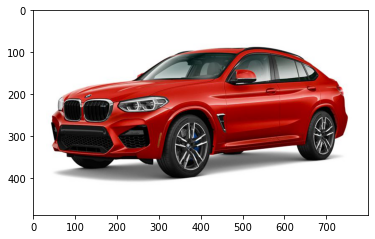

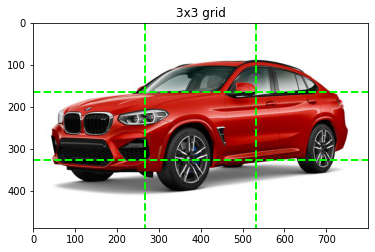

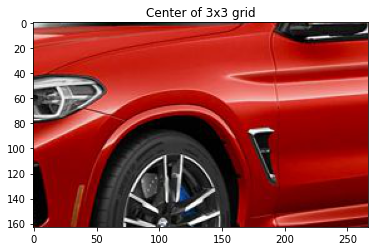

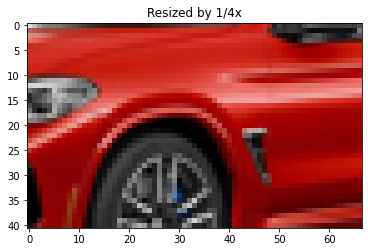

firebrick (178, 34, 34)


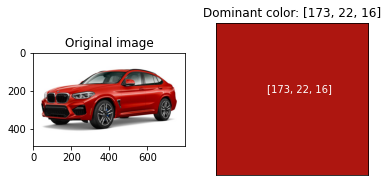

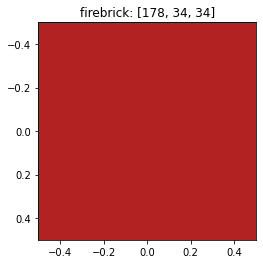

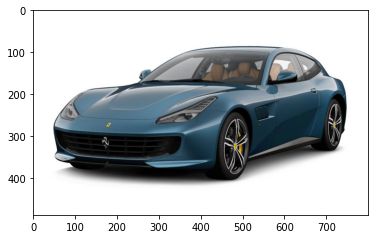

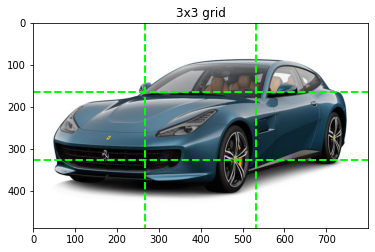

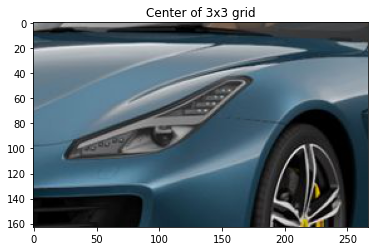

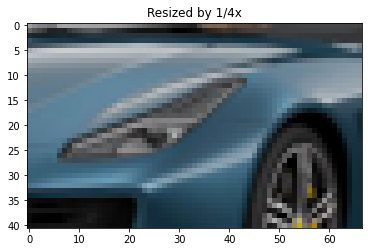

lightslategray (119, 136, 153)


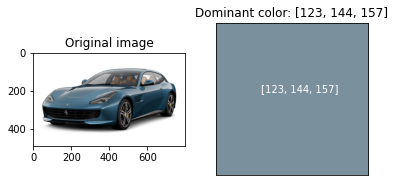

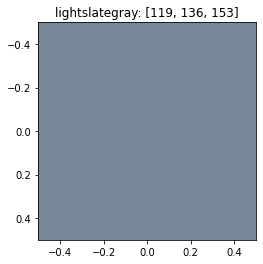

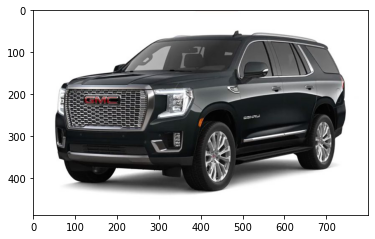

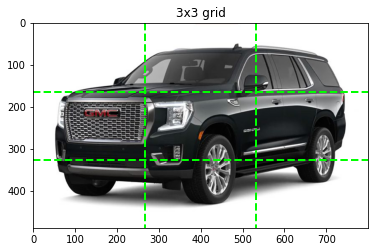

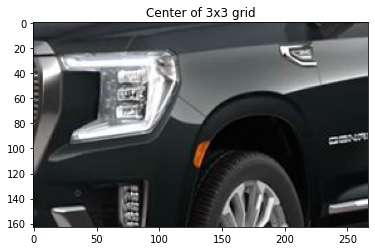

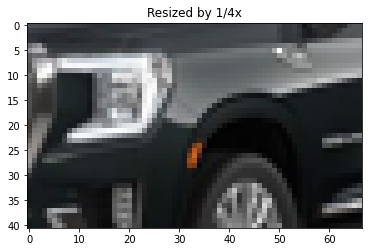

black (0, 0, 0)


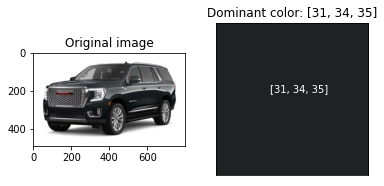

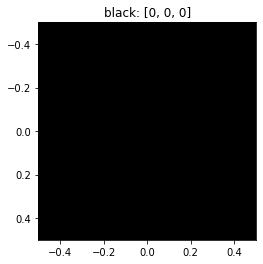

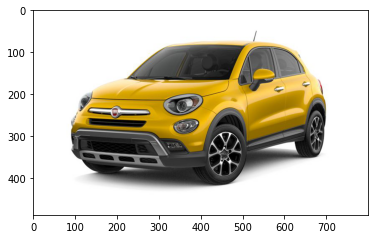

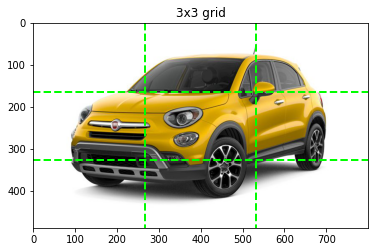

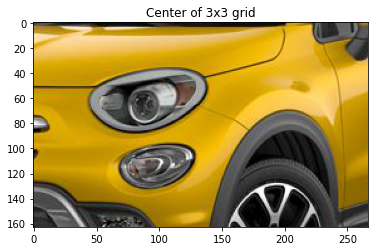

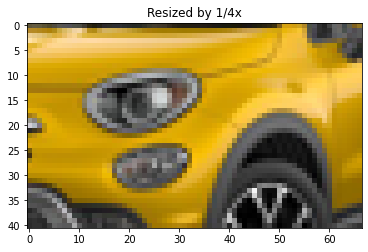

darkgoldenrod (184, 134, 11)


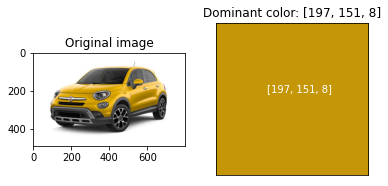

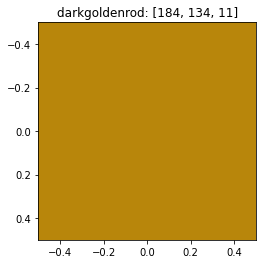

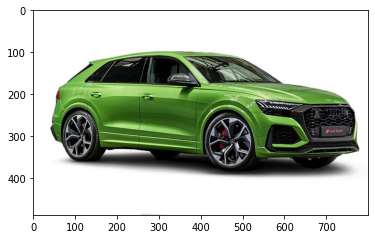

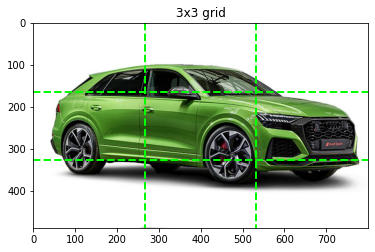

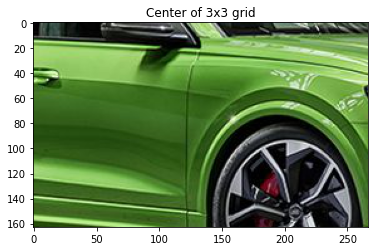

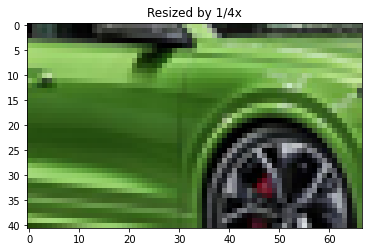

darkolivegreen (85, 107, 47)


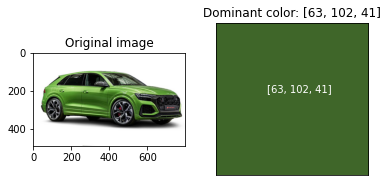

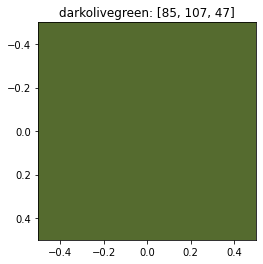

In [ ]:
from PIL import Image
from io import BytesIO
import requests

import numpy as np
import matplotlib.pyplot as plt
factor = 4

test_images = [
    'https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/vdat/submodels/bmw_x4-m_bmw-x3-m_2022-1629740310609.jpg',
    'https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/7554.jpg',
    'https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/vdat/submodels/gmc_yukon-yukon-xl_gmc-yukon_2022-1634066047069.jpg',
    'https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/8547.jpg',
    'https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/vdat/submodels/audi_rs-q8_audi-rs-q8_2021-1601930319922.jpg'
]

for img_url in test_images:
    # Capture the image for display in the plot_image_color_comparison() function
    pil_img = Image.open(BytesIO(requests.get(img_url).content))
    
    pixel_array = preprocess_image(
        img_path=img_url, 
        is_url=True, 
        scale_factor=4, 
        scale_mode='resize', 
        crop_center=True, 
        display_img=True,
        quiet=True, 
        scale_rgb=False)
    
    best_clusters = optimal_nclusters_elbow(
        data=pixel_array, 
        max_clusters=10, 
        random_state=0,
        plot_data=False,
        quiet=True)
    # Get the name of the closest color
    color_name = get_color_name(best_clusters['dominant_rgb'])
    print(color_name['name'], color_name['rgb'])
    
    # Display image with guessed color
    plot_image_color_comparison(pil_img, RGB_col=best_clusters['dominant_rgb'])

    # Display closest named color
    rgb_square = np.array(list(color_name['rgb']))
    plt.title(color_name['name'] + ': ' + str(list(color_name['rgb'])))
    plt.imshow(rgb_square.reshape(1,1,3))
    plt.show()
    print('\n')
    # break